In [1]:
%matplotlib inline

In [2]:
from pc import *

# Quick Motivation #
From our own solar system and observations of exoplanets, we have identified various sub-types of planets. In future direct imaging missions such as [LUVOIR (the Large UV/Optical/IR surveyor)](https://asd.gsfc.nasa.gov/luvoir/reports/), we'll survey nearby stars to identify exo-Earth candidates. The problem is that getting a detailed snapshot of exo-Earth atmospheres is *extremely* time-intensive, of order days to years, even for nearby stellar systems. So, the observing strategy is to weed out non-Earth like planets, using techniques/thresholds with increasingly more telescope resources. 

In other words, we need to test how well direct imaging surveys can disambiguate planet classes, using as few resources as possible, to maximize the final yield of exo-Earths. In particular, "mini" or sub-Neptunes -- planets slightly larger in size than Earth with large gaseous envelopes which may be water rich -- pose the largest threat as Earth impostors.

For this purpose, we'll group the various sub-types of planets into 4 (known) major classes of planets: 
  - oxic Earths (eg modern & proterozoic Earth)
  - anoxic Earths (eg Archean Earth)
  - gas giants (eg Saturn, Jupiter)
  - Neptunian objects (including Uranus, mini Neptunes)
 
We'll use spectra based on observations of Solar System objects and physical simulations to test supervised learning of planet classes.


# Load in spectral data #

Spectra of modern day Solar System objects are based on observations, while Hazy Archean & Proterozoic Earths, warm/cold Neptunes are based on models. The Neptunian model/simulated spectra are generated by two different groups, where the MacDonald+2018 form the most complete set in terms of parameter space explored. 

Let's call these the fiducial data. Because they have from different provenances and do not uniformly fill label space, we'll have to do some standardizations to the data before we can apply the supervised learning techniques; more on this later.

In [3]:
#################################################################################
### load in cold Neptunian spectra from MacDonald+2018, SS spectra from Giada ###
#################################################################################

#m,g,T,fsed range are MacDonald grids in metallicity, gravity, temperature, cloud sedimentation
mrange = np.array([0, 1., 2.])
grange = np.arange(2.0, 3.7, 0.2)
Trange = np.arange(150, 401, 30).astype(int)
fsedrange = np.array([1, 9])

# uniform grid of subNeptune spectra from MacDonald+2018
data = load_mn_spectra(mrange, grange, Trange, fsedrange)
# wavelength grid of MacDonald+2018 dataset
lam = data[0,0,0,0,:,0]

# supplement with Solar System object spectra from VPL
modern_earth = np.loadtxt('data/ga_ss_spectra/Earth_geo_albedo.txt')
hazy_archean_earth = np.loadtxt('data/ga_ss_spectra/Hazy_ArcheanEarth_geo_albedo.txt')
jupiter = np.loadtxt('data/ga_ss_spectra/Jupiter_geo_albedo.txt')
neptune = np.loadtxt('data/ga_ss_spectra/Neptune_geo_albedo.txt')
proterozoic_hiO2 = np.loadtxt('data/ga_ss_spectra/proterozoic_hi_o2_geo_albedo.txt')
proterozoic_loO2 = np.loadtxt('data/ga_ss_spectra/proterozoic_low_o2_geo_albedo.txt')
uranus = np.loadtxt('data/ga_ss_spectra/Uranus_geo_albedo.txt')
saturn = np.loadtxt('data/ga_ss_spectra/Saturn_geo_albedo.txt')
warm_nep1au_cloud = np.loadtxt('data/ga_ss_spectra/warm_neptune_1au_clouds.txt')
warm_nep1au_nocloud = np.loadtxt('data/ga_ss_spectra/warm_neptune_1au_noclouds.txt')
warm_nep2au = np.loadtxt('data/ga_ss_spectra/warm_neptune_2au.txt')

# the warm nep spectra have different units
warm_nep1au_cloud[:,0]*=1e-3
warm_nep1au_nocloud[:,0]*=1e-3
warm_nep2au[:,0]*=1e-3

### Make data uniform:

Make wavelength (independent variable) sampling the same for the different data sets, and plot the original and uniform data as a quick validity check

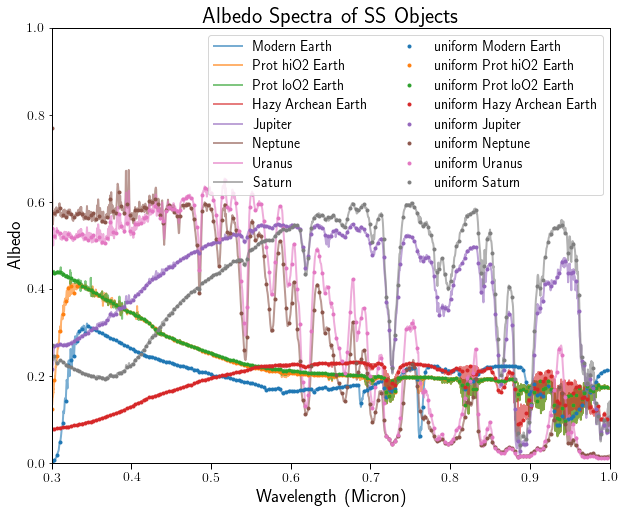

In [4]:
### collect all SS planet spectra into single matrix &
### make uniform on same wavelength grid as sub-Neptunes data

ss_header_keys = ['Modern Earth', 'Prot hiO2 Earth', 'Prot loO2 Earth', 'Hazy Archean Earth', 
             'Jupiter', 'Neptune', 'Uranus', 'Saturn']

ss = np.zeros((len(ss_header_keys), 2000))

ss_header = dict(zip(ss_header_keys, np.arange(len(ss_header_keys))))

ss[0,:] = make_spectrum_uniform(lam, modern_earth[:,0], modern_earth[:,1])
ss[1,:] = make_spectrum_uniform(lam, proterozoic_hiO2[:,0], proterozoic_hiO2[:,1])
ss[2,:] = make_spectrum_uniform(lam, proterozoic_loO2[:,0], proterozoic_loO2[:,1])
ss[3,:] = make_spectrum_uniform(lam, hazy_archean_earth[:,0], hazy_archean_earth[:,1])
ss[4,:] = make_spectrum_uniform(lam, jupiter[:,0], jupiter[:,1])
ss[5,:] = make_spectrum_uniform(lam, neptune[:,0], neptune[:,1])
ss[6,:] = make_spectrum_uniform(lam, uranus[:,0], uranus[:,1])
ss[7,:] = make_spectrum_uniform(lam, saturn[:,0], saturn[:,1])


### plot original data and thinned, uniform matrix
plt.figure(figsize=(10,8))
plt.plot(modern_earth[:,0], modern_earth[:,1], lw=2, color='C0', 
         alpha=0.6, label='Modern Earth')
plt.plot(proterozoic_hiO2[:,0], proterozoic_hiO2[:,1], lw=2, alpha=0.6, 
         color='C1', label='Prot hiO2 Earth')
plt.plot(proterozoic_loO2[:,0], proterozoic_loO2[:,1], lw=2, alpha=0.6, 
         color='C2', label='Prot loO2 Earth')
plt.plot(hazy_archean_earth[:,0], hazy_archean_earth[:,1], lw=2, alpha=0.6, 
         color='C3', label='Hazy Archean Earth')
plt.plot(jupiter[:,0], jupiter[:,1], lw=2, alpha=0.6, color='C4', label='Jupiter')
plt.plot(neptune[:,0], neptune[:,1], lw=2, alpha=0.6, color='C5', label='Neptune')
plt.plot(uranus[:,0], uranus[:,1], lw=2, alpha=0.6, color='C6', label='Uranus')
plt.plot(saturn[:,0], saturn[:,1], lw=2, alpha=0.6, color='C7', label='Saturn')
for i,ss_label in enumerate(ss_header_keys):
    plt.plot(data[0,0,0,0,:,0][::10], ss[i,:][::10], '.', 
             label="uniform {}".format(ss_label), color='C{}'.format(i))
plt.xlim((0.3, 1.0))
plt.legend(ncol=2)
plt.ylim((0., 1.0))
plt.ylabel("Albedo")
plt.xlabel("Wavelength (Micron)")
plt.title("Albedo Spectra of SS Objects")

### Standardize Features/Augment data: 

There are two issues with the current data sets:
 - (1) There are a whole lot more Neptunian labels than, e.g., Earths, b/c MacDonald+2018 use a finer physical grid to generate simulated spectra.
 - (2) The MacDonald+2018 grid is sampled in $g$ rather than mass and radius.

We can help address both issues by standardizing the features to include mass and radius for all labels. Let's 
 - (1) Expand the Solar System data grid by allowing each SS object to take on radius = 0.85-1.15 times fidual values. 
 - (2) Convert 1D grid in $g$ (w/ length $N_g$) to 2D grid in mass (w/ length $N_M$), radius (size $N_M, N_g$) for MacDonald+2018 dataset, using the scaling relation $g~M/R^2$. 

logg 2.0, Crit Radius 0.971446245548
logg 2.2, Crit Radius 1.03815649767
logg 2.4, Crit Radius 1.1104483063
logg 2.6, Crit Radius 1.18872147251
logg 2.8, Crit Radius 1.27340813927
logg 3.0, Crit Radius 1.36497516923
logg 3.2, Crit Radius 1.46392671083
logg 3.4, Crit Radius 1.570806967
logg 3.6, Crit Radius 1.68620318144
SS radius (300, 8) shapes
MN mass (10,), radius (10, 9), grange (9,) shapes


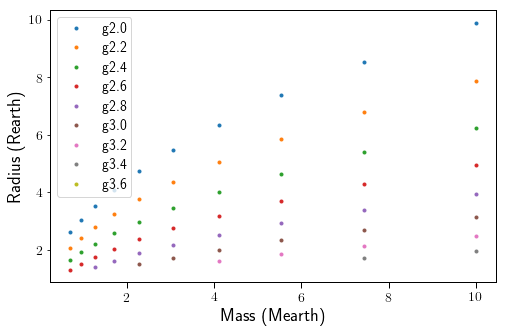

In [5]:
###############################################################################
########### simulate mass, radius for mini-neptunes and ss objects, ###########
########### identify unphysical MNs via Lopez & Fortney (2014)      ###########
###############################################################################

# radius grid of fiducial solar system objects, in Earth radius
radius_ss0 = np.array([1.0, 1.0, 1.0, 1.0, 10.96, 3.86, 3.98, 9.13])

Naugment_ss = 300
# stretch radius grid for larger and smaller planets
radius_ss = np.linspace(0.85, 1.15, Naugment_ss, endpoint=True)[:, np.newaxis] * radius_ss0

# for grange, get possible mass/radius combinations
mass_mn, radius_mn = simulate_planets(grange, mi=0.7, Nm=10)
# for each possible mass, get critical radius below which sub-Neptune state not likely physical
crit_mn_radius = get_sub_neptune_radius(mass_mn, f_env=0.01)

block = (radius_mn*0.0).astype(bool)

# plot the mass-radius grid for MNs, masking out unphysical objects 
plt.figure()
for ii in range(radius_mn.shape[-1]):
    block[:,ii] = (radius_mn[:,ii] <= crit_mn_radius[ii])
    print("logg {}, Crit Radius {}".format(grange[ii], crit_mn_radius[ii]))
    plt.plot(mass_mn[~block[:,ii]], radius_mn[~block[:,ii], ii], '.', 
             label='g{}'.format(grange[ii]))
plt.xlabel('Mass (Mearth)')
plt.ylabel('Radius (Rearth)')
plt.legend()
#plt.yscale('log')
#plt.xscale('log')
print("SS radius {} shapes".format(radius_ss.shape))
print("MN mass {}, radius {}, grange {} shapes".format(mass_mn.shape, radius_mn.shape, grange.shape))

### Downsample feature space (spectral grid) & transform from intrinsic luminosity to brightness

The data is currently finely sampled in wavelength. In reality, we'll observe the "bandpass brightness", or the integrated flux from $\lambda_i$ to $\lambda_f$, the inner and outer edges of a bandpass. (More spectral resolution = more expensive and time-intensive). This reduces dimensions from wavelength grid ~2000 to the number of bandpasses Nbp~10.

Instead of using albedo (intrinsic luminosity) as features to learn, we'll use bandpass brightness in magnitudes (log space). 

In [6]:
###############################################################################
########### simulate bandpass observations of each MN + SS object   ###########
########### assign class and other labels when possible #######################
###############################################################################

### Organize each sub-type of planet (Jupiter, Saturn, Modern/Protoz. Earth, Neptunes) into 4 major classes: 
class_labels_dict = {'0': "Neptunes", '1': "Modern Earth", '2': "Archean Earth",
                     '3': "Gas Giants"}
                     
target_labels_header = dict(zip(['class', 'mass', 'radius', 'm', 'T', 'fsed', 'unphysical', 'name'], 
                                np.arange(8)))


### Get wavelength info
wave_in, wave_out = 0.3, 1.0
Nbp = 10
cbp = 0.14
bp = 0.15

# central, initial, final, and avg wavelength value for each bandpass
lam_c, lam_i, lam_f = get_central_bandpass(wave_in*1e3, wave_out*1e3, 
                                           bp=bp, cbp=cbp, Nbp=Nbp, ret_all=True)

lam_avg = get_avg_albedo(lam, lam, lam_i*1e-3, lam_f*1e-3)

### assign appropriate features (brightness in magnitudes in various bandpass) and class labels for SS data
mags_ss = np.zeros((len(ss_header), radius_ss.shape[0], Nbp))
targets_ss = np.zeros((mags_ss.shape[0], mags_ss.shape[1], len(target_labels_header)))
# print("mags_ss size {}".format(mags_ss.shape))

for ii in range(len(ss_header)):
    for jj in range(radius_ss.shape[0]):
        mags_ss[ii,jj,:] = -2.5 * (np.log10(get_avg_albedo(lam, ss[ii,:], lam_i*1e-3, lam_f*1e-3)) +\
                                   2.*np.log10(radius_ss[jj,ii]))
        targets_ss[ii,jj,2] = radius_ss[jj,ii]
        
# assign class
targets_ss[:3, :, 0] = 1 #modern/prot earth
targets_ss[3, :, 0] = 2 #archean earth
targets_ss[[4,7], :, 0] = 3 #gas giants
targets_ss[[5,6], :, 0] = 0 #make neptune and uranus in same class as mini neptunes

# assign planet sub-type (where its fiducial model came from)
targets_ss[0, :, -1] = 0
targets_ss[1, :, -1] = 1
targets_ss[2, :, -1] = 2
targets_ss[3, :, -1] = 3
targets_ss[4, :, -1] = 4
targets_ss[5, :, -1] = 5
targets_ss[6, :, -1] = 6
targets_ss[7, :, -1] = 7


### assign appropriate features (brightness in magnitudes in various bandpass) and class labels for MN data
mags_mn = np.zeros((data.shape[0]*data.shape[2]*data.shape[3], radius_mn.shape[1], radius_mn.shape[0], Nbp))
target_labels_mn = np.zeros((mags_mn.shape[0], mags_mn.shape[1], mags_mn.shape[2], len(target_labels_header)))
ijk=0
# loop over mrange (metal), Trange, fsed
for i,k,l in itertools.product(range(data.shape[0]), 
                                 range(data.shape[2]),
                                 range(data.shape[3])): 
    if ijk % 500 == 0:
        print(ijk)
    for ii in range(radius_mn.shape[1]): #over grange (different radius for given mass)
        for jj in range(radius_mn.shape[0]): #over mass grid = 20
            mags_mn[ijk,ii,jj,:] = -2.5 * (np.log10(get_avg_albedo(lam, data[i,ii,k,l,:,1], 
                                                                   lam_i*1e-3, lam_f*1e-3)) + \
                                           2*np.log10(radius_mn[jj,ii]))
            target_labels_mn[ijk,ii,jj,1:] = mass_mn[jj], radius_mn[jj,ii], mrange[i], Trange[k],\
                                                fsedrange[l], block[jj,ii], -1
    ijk+=1


mags_ss = mags_ss.reshape((ss.shape[0]*radius_ss.shape[0], Nbp))
targets_ss = targets_ss.reshape((ss.shape[0]*radius_ss.shape[0], 
                                 len(target_labels_header)))

mags_mn = mags_mn.reshape((ijk*radius_mn.shape[1]*radius_mn.shape[0], Nbp))
target_labels_mn = target_labels_mn.reshape((ijk*radius_mn.shape[1]*radius_mn.shape[0], 
                                             len(target_labels_header)))

# get rid of unphysical/bad simulations
mags_mn0 = mags_mn.copy()
target_labels_mn0 = target_labels_mn.copy()
bad = (target_labels_mn[:, -2] == 1)
mags_mn = mags_mn[~bad, :]
target_labels_mn = target_labels_mn[~bad, :]

### combine SS and MN data
all_mags = np.vstack((mags_ss, mags_mn))
all_targets = np.concatenate((targets_ss[:,0], target_labels_mn[:,0]))

all_labels = np.zeros((targets_ss.shape[0]+target_labels_mn.shape[0], 
                       target_labels_mn.shape[1])) * np.nan
all_labels[targets_ss.shape[0]:, :] = target_labels_mn
all_labels[:targets_ss.shape[0], :] = targets_ss

Number of bandpasses = 10
0


In [7]:
for i, lm in enumerate(zip(lam_i, lam_f)):
    print("bandpass {} wavelength range: {:.1f} - {:.1f}".format(i, lm[0], lm[1]))
mags_mn.shape, mags_ss.shape

bandpass 0 wavelength range: 296.9 - 345.1
bandpass 1 wavelength range: 338.5 - 393.4
bandpass 2 wavelength range: 385.9 - 448.5
bandpass 3 wavelength range: 439.9 - 511.2
bandpass 4 wavelength range: 501.5 - 582.8
bandpass 5 wavelength range: 571.7 - 664.4
bandpass 6 wavelength range: 651.7 - 757.4
bandpass 7 wavelength range: 743.0 - 863.5
bandpass 8 wavelength range: 847.0 - 984.4
bandpass 9 wavelength range: 925.0 - 1075.0


((3240, 10), (2400, 10))

### Make a plot showing before/after standardizing the data, with a few planet class examples

Top panel shows the raw data, middle panel shows the bandpass/filter coverage in wavelength space, and bottom panel shows the standardized data. Because brightness is defined in magnitudes: more negative value = brighter, more positive value = dimmer. Mini-Neptunes appear the most similar to Earth-like planets. 

In [8]:
ss_header_r = {y:x for x,y in ss_header.iteritems()}

def map_val_to_str(label, val):
    """Map value associated with label to string qualifier, eg T<270 = cold."""
    if label == 'T':
        if val < 270:
            descriptor = 'cold'
        else:
            descriptor = 'warm'
    elif label == 'm':
        if val < 1:
            descriptor = 'metal-poor'
        elif val > 1:
            descriptor = 'metal-rich'
        else:
            descriptor = ''
    elif label == 'g':
        if val < 2.8:
            descriptor = 'low gravity'
        else:
            descriptor = 'high gravity'
    elif label == 'name':
        descriptor = ss_header_r[val]
    elif label == 'radius':
        if val < 4:
            descriptor = 'mini-'
        else:
            descriptor = ''
    else:
        descriptor = ''
    return descriptor

def get_full_descriptor(labels, vals):
    """Join multiple labels to get full descriptor from list of labels, values"""
    descriptors = [map_val_to_str(label, val) for label, val in zip(labels, vals)]
    return ' '.join(["{}".format(single_des) for single_des in descriptors])


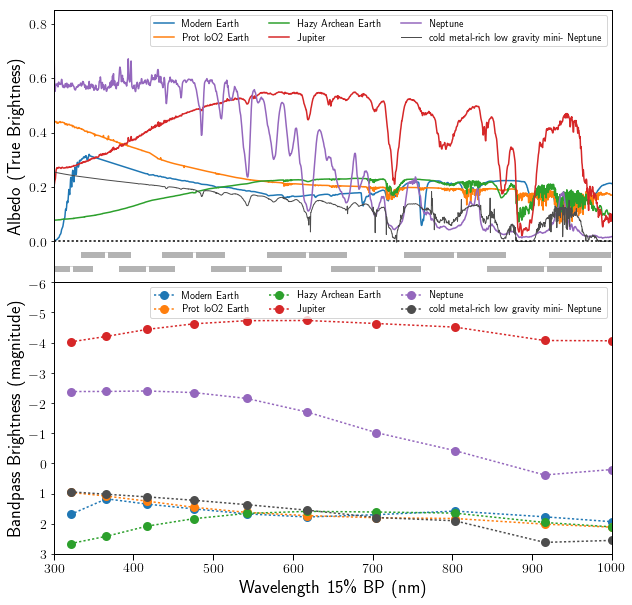

In [9]:
sel = (mags_mn[:,0]>0.7)
jj = np.arange(target_labels_mn.shape[0])[sel]

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1)
# plot fiducial data
for ii, ss_label in enumerate(['Modern Earth', 'Prot loO2 Earth', 'Hazy Archean Earth', 'Jupiter', 'Neptune']):
    ax1.plot(lam*1e3, ss[ss_header[ss_label],:], label=ss_label, color='C{}'.format(ii))

# plot "observed" data
rand_obs_inds = []
for ss_label in ['Modern Earth', 'Prot loO2 Earth', 'Hazy Archean Earth', 'Jupiter', 'Neptune']:
    rand_obs_inds.append(np.random.choice(np.arange(targets_ss.shape[0])[targets_ss[:,-1] == ss_header[ss_label]], 1)[0])

for ii in rand_obs_inds:#range(targets_ss.shape[0])[radius_ss.shape[0]/2:radius_ss.shape[0]*(ss.shape[0]-4):radius_ss.shape[0]]:
    ax2.plot(lam_c, mags_ss[ii,:], 'o:', mew=3, label="{}".format(ss_header_r[targets_ss[ii,-1]]))
    
for jj in np.arange(target_labels_mn.shape[0])[sel]:
    _gi, _mi, _Ti, _fi = map_obs_to_fiducial(jj, target_labels_mn, target_labels_header, 
                                        mrange, grange, Trange, fsedrange)
    descriptor = get_full_descriptor(['T', 'm', 'g', 'radius', 'name'], 
                                     [_Ti, _mi, _gi, target_labels_mn[jj,target_labels_header['radius']], 5])
    ax1.plot(lam*1e3, data[_gi,_mi,_Ti,_fi,:,1], lw=1, color='0.3', #data[0,2,-1,-1,:,1], lw=1, color='0.7', 
                                     label=descriptor)
    ax2.plot(lam_c, mags_mn[jj,:], 'o:', mew=3, color='0.3', label=descriptor)
ax1.set_xlim((300, 1000))
ax1.legend(ncol=3, fontsize=10)
ax1.axhline(0, ls=':', lw=1.5, color='k')
ax1.set_ylim((-0.15, 0.85))

for cnter, lstuff in enumerate(zip(lam_c, lam_i, lam_f)):
    lc, li, lf = lstuff
    ax1.plot([li, lf], [-0.1+(cnter%2)*0.05]*2, lw=6, alpha=1.0, color='0.7') #color="C{}".format(cnter%10))
    ax1.plot(lc, -0.1+(cnter%2)*0.05, marker='|', mew=3, color='w')#color="C{}".format(cnter%10))

ax1.set_ylabel("Albedo (True Brightness)")
ax1.get_xaxis().set_visible(False)

ax2.invert_yaxis()
ax2.set_ylim(3, -6)
ax2.legend(ncol=3, fontsize=10)
ax2.set_xlabel('Wavelength {}\% BP (nm)'.format(int(bp*100)))
ax2.set_ylabel('Bandpass Brightness (magnitude)')
plt.subplots_adjust(hspace=0)
plt.savefig("example_spectra.png", dpi=100)

### Prep classification analysis and split standardized data into training and test set

In [10]:
###############################################################################
#########Split into Training & Test data, and run different analysis   ########
###############################################################################

###### ind_weight = np.ones(all_mags.shape[0])
mask_ss = (all_labels[:, target_labels_header['class']]>0)
mask_mn = (all_labels[:, target_labels_header['class']]==0)
N_ss = mask_ss.sum()
N_mn = mask_mn.sum()
ind_weight = np.ones(all_mags.shape[0])
ind_weight[mask_ss] = 0.5/N_ss
ind_weight[mask_mn] = 0.5/N_mn
Ntrain = int(0.6*all_mags.shape[0])

train_set = np.random.choice(np.arange(all_mags.shape[0]), size=Ntrain, replace=False)
test_set = np.arange(all_mags.shape[0]).astype(int)[~np.in1d(np.arange(all_mags.shape[0]), train_set)]
Ntest = len(test_set)

Ntest_sets = 100
test_i_size = int((0.6*Ntest))

test_set_i = get_ith_test_set(test_set, ind_weight[test_set]/np.nansum(ind_weight[test_set]),
                              test_i_size, Nsubsets=Ntest_sets)

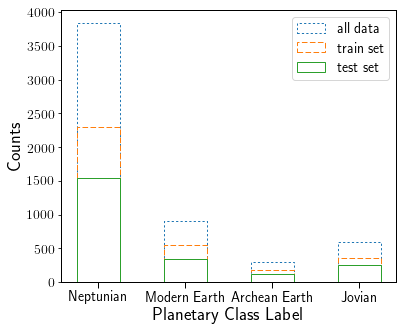

In [11]:
classbinedges = np.linspace(0, 3.5, 8)
plt.figure(figsize=(6,5))
#plt.hist(all_labels[training_set,0], histtype='step', ls='--', normed=True)
plt.hist(all_labels[:,0], bins=classbinedges, histtype='step', ls=':', label='all data')# normed=True)
plt.hist(all_labels[train_set,0], bins=classbinedges, histtype='step', ls='--', label='train set')# normed=True)
plt.hist(all_labels[test_set,0],bins=classbinedges,  histtype='step', ls='-', label='test set')# normed=True)
plt.legend()
plt.xticks((classbinedges[:-1:2]+classbinedges[1::2])*0.5, ['Neptunian', 'Modern Earth', 'Archean Earth', 'Jovian'])
plt.xlabel('Planetary Class Label')
plt.ylabel('Counts')

### Use LDA to find the best bandpass/filter combinations for N=3 

99.91+/-0.06% accuracy for 3 bandpasses centered on 321.0 365.9 475.6
99.80+/-0.17% accuracy for 3 bandpasses centered on 321.0 365.9 542.2
99.80+/-0.10% accuracy for 3 bandpasses centered on 365.9 417.2 704.6
99.79+/-0.09% accuracy for 3 bandpasses centered on 365.9 475.6 704.6
99.78+/-0.10% accuracy for 3 bandpasses centered on 365.9 417.2 915.7
99.77+/-0.12% accuracy for 3 bandpasses centered on 365.9 542.2 704.6
99.75+/-0.10% accuracy for 3 bandpasses centered on 365.9 417.2 803.2
99.73+/-0.10% accuracy for 3 bandpasses centered on 321.0 417.2 475.6
99.73+/-0.11% accuracy for 3 bandpasses centered on 417.2 475.6 704.6
99.73+/-0.12% accuracy for 3 bandpasses centered on 365.9 475.6 542.2


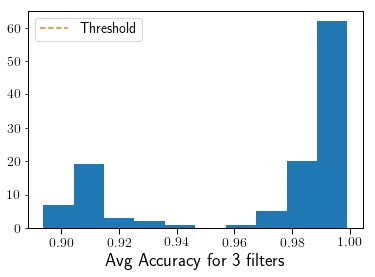

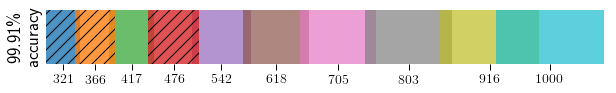

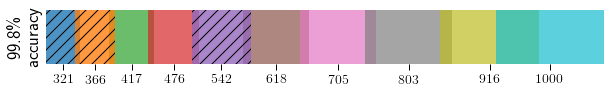

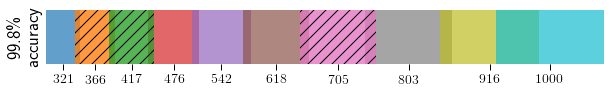

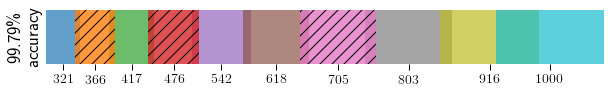

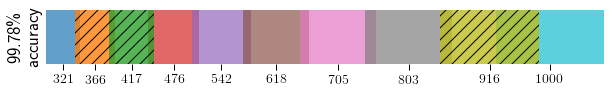

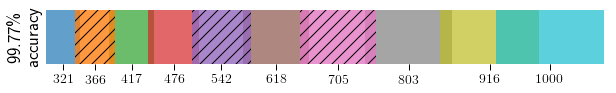

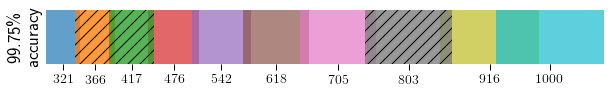

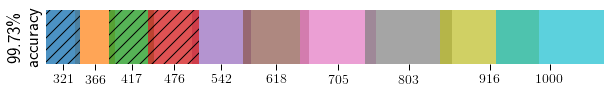

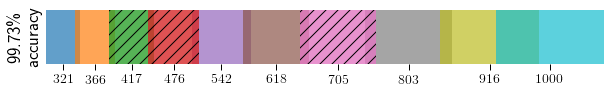

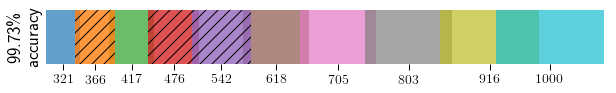

In [12]:
good_filters, good_acc_mean, good_acc_std = apply_LDA(3, all_mags, all_targets, train_set, 
                                                      test_set, test_set_i, Nbp, topX=10)#acc_thresh=0.998)

for gf, gam in zip(good_filters, good_acc_mean):
    plot_filter_set(lam_i, lam_f, lam_c, filter_choice=gf, 
                    ylabel='{}\% \n accuracy'.format(np.round(gam*100, 2)))


for gf,gam,gas in zip(good_filters, good_acc_mean, good_acc_std):
    print("{:.2f}+/-{:.2f}% accuracy for {} bandpasses centered on {}".format(gam*100, gas*100, len(gf), 
                                                         " ".join([str(np.round(lc, 1)) for lc in lam_c[gf]])))

### Now apply to N=2, 3, 5, 7, 9 bandpasses/filters and get best filter combination & corresponding accuracy for each N.

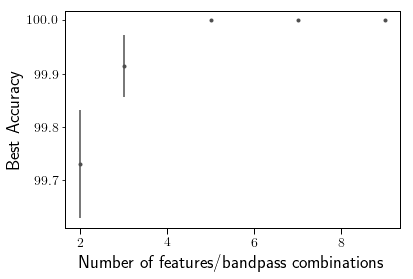

In [21]:
Nchoose_array = [2, 3, 5, 7, 9]
best_accuracy = np.zeros((len(Nchoose_array), 2))
best_filters = []

for zz in range(len(Nchoose_array)):
    good_filters, good_acc_mean, good_acc_std = apply_LDA(Nchoose_array[zz], all_mags, 
                                                          all_targets, train_set, 
                                                          test_set, test_set_i, Nbp, topX=1, plot=False)
    best_filters.append(good_filters[0])
    best_accuracy[zz,:] = good_acc_mean[0], good_acc_std[0]
    
plt.figure(figsize=(6,4))
plt.errorbar(Nchoose_array, best_accuracy[:,0]*100., 
             best_accuracy[:,1]*100., fmt='.', color='.3')
plt.xlabel('Number of features/bandpass combinations')
plt.ylabel('Best Accuracy')

### Best filter combination for N=2

LUVOIR can take simultaneous observations in 2 bandpasses. So let's plot the results for N=2 and see if the space different planet classes occupy are well-separated by the optimized filter set. 

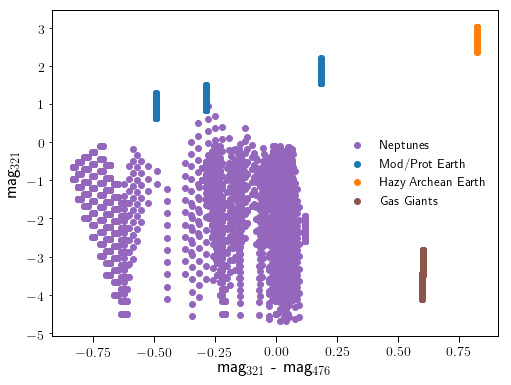

In [14]:
plt.figure(figsize=(8,6))
plt.scatter((all_mags[:,best_filters[0][0]]-all_mags[:,best_filters[0][1]])[all_labels[:,0]==0], 
            (all_mags[:,best_filters[0][0]])[all_labels[:,0]==0], 
         color='C4', label='Neptunes')
plt.scatter((all_mags[:,best_filters[0][0]]-all_mags[:,best_filters[0][1]])[all_labels[:,0]==1], 
            (all_mags[:,best_filters[0][0]])[all_labels[:,0]==1],
         color='C0', label='Mod/Prot Earth', )
plt.scatter((all_mags[:,best_filters[0][0]]-all_mags[:,best_filters[0][1]])[all_labels[:,0]==2], 
            (all_mags[:,best_filters[0][0]])[all_labels[:,0]==2],
         color='C1', label='Hazy Archean Earth')
plt.scatter((all_mags[:,best_filters[0][0]]-all_mags[:,best_filters[0][1]])[all_labels[:,0]==3], 
            (all_mags[:,best_filters[0][0]])[all_labels[:,0]==3],
         color='C5', label='Gas Giants')
           
plt.xlabel('mag$_{{{}}}$ - mag$_{{{}}}$'.format(np.round(lam_c[best_filters[0][0]],0).astype(int), 
                                                np.round(lam_c[best_filters[0][1]],0).astype(int)))
plt.ylabel('mag$_{{{}}}$'.format(np.round(lam_c[best_filters[0][0]],0).astype(int)))
plt.legend(fontsize=13, frameon=False)
plt.savefig('colour_colour.png', dpi=100)
plt.show()

# LDA + feature selection on "noisy" data

Real data/observations will have noise. Simulate noisy observations by injecting Gaussian noise consistent at various SNR levels. Achieving a higher SNR in real observations means dedicating more telescope time (to collect more photons). 

In [15]:
snr_levels = [30, 10, 7, 5, 3]
all_mags_noisy = np.zeros((len(snr_levels), all_mags.shape[0], all_mags.shape[1]))
for ii in range(len(snr_levels)):
    np.random.seed(ii)
    all_mags_noisy[ii,:] = all_mags + get_noise(all_mags, 
                                          dx=abs(-2.5/(snr_levels[ii]*np.log(10.))))

### Plot example noisy data against noiseless data for comparison

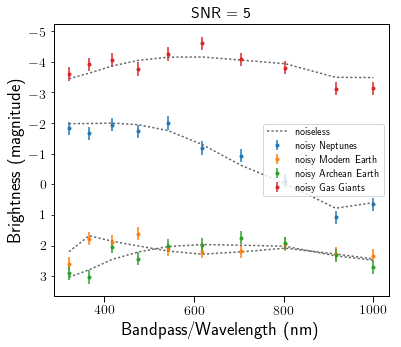

In [16]:
jj=3
fig,ax=plt.subplots(figsize=(6,5))
for ii in [0, 1, 2, 3]:
    ax.errorbar(lam_c, all_mags_noisy[jj, all_targets==ii,:][0,:], 
                  abs(-2.5/(snr_levels[jj]*np.log(10.))), fmt='.', 
                 color="C{}".format(ii),
                label="noisy {}".format(class_labels_dict[str(ii)]))
    if ii==0:
        ax.plot(lam_c, all_mags[all_targets==ii,:][0,:], ':', color='0.4', label='noiseless')
    else:
        ax.plot(lam_c, all_mags[all_targets==ii,:][0,:], ':', color='0.4')
ax.legend(fontsize=10)
ax.set_xlabel('Bandpass/Wavelength (nm)')
ax.set_ylabel('Brightness (magnitude)')
ax.invert_yaxis()
ax.set_title("SNR = {}".format(snr_levels[jj]), fontsize=16)
#plt.title('Using BP sets trained on noiseless data', fontsize=16)

### First, test recovery with optimized bandpass sets from noiseless data"

Train/predict on noisy data using the best set of bandpasses/filters from above.

In [22]:
###############################################################################
######### Do analysis for different noise levels ########
###############################################################################

test_set_i2 = get_ith_test_set(test_set, ind_weight[test_set]/np.nansum(ind_weight[test_set]),
                              test_i_size, Nsubsets=Ntest_sets, seed=False)

accuracy_with_noise = np.zeros((len(snr_levels), len(best_filters), Ntest_sets))

for ii in range(len(snr_levels)):
    for jj in range(len(best_filters)):
        X_train = all_mags_noisy[ii, train_set,:][:, best_filters[jj]]
        Y_train = all_targets[train_set]
        X_train = StandardScaler().fit_transform(X_train)
        lda = LinearDiscriminantAnalysis(store_covariance=True)
        X_r2 = lda.fit(X_train, Y_train).transform(X_train)
        for kk in range(Ntest_sets):
            X_test = all_mags_noisy[ii, test_set_i2[:,kk],:][:, best_filters[jj]]
            X_test = StandardScaler().fit_transform(X_test)
            Y_test = all_targets[test_set_i2[:,kk]]
            lda_pred = lda.predict(X_test)
            lda_wrong = (abs(lda_pred-Y_test)>0)
            accuracy_with_noise[ii, jj, kk] = 1.-lda_wrong.sum()/float(X_test.shape[0])

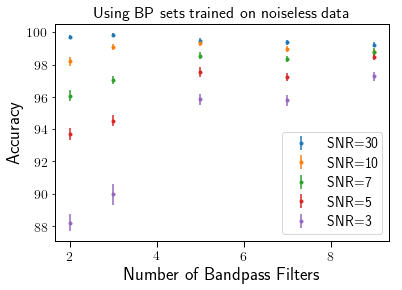

In [23]:
plt.figure(figsize=(6,4))
for ii in range(len(snr_levels)):
    plt.errorbar(Nchoose_array, np.nanmean(accuracy_with_noise[ii, :, :], axis=-1)*100, 
                 np.nanstd(accuracy_with_noise[ii, :, :], axis=-1)*100., fmt='.', 
                 color="C{}".format(ii),
                label="SNR={}".format(snr_levels[ii]))
plt.legend()
plt.xlabel('Number of Bandpass Filters')
plt.ylabel('Accuracy')
plt.title('Using BP sets trained on noiseless data', fontsize=16)

### Optimize filter combination for noisy data

Not surprisingly, the filters optimized for noiseless data perform more poorly for noisy data. Retrain using noisy data.

In [24]:
best_accuracy_noise = np.zeros((len(snr_levels), len(Nchoose_array), 2))
best_filters_noise = []

for jj in range(len(snr_levels)):
    for zz in range(len(Nchoose_array)):
        good_filters, good_acc_mean, good_acc_std = apply_LDA(Nchoose_array[zz], all_mags_noisy[jj,:,:], 
                                                              all_targets, train_set, 
                                                              test_set, test_set_i, Nbp, topX=1, plot=False)
        best_filters_noise.append(good_filters[0])
        best_accuracy_noise[jj, zz,:] = good_acc_mean[0], good_acc_std[0]

### Plot results. 

At SNR=10 (the nominal level for LUVOIR), the accuracy is >99% with just using 2 bandpasses. 

It makes sense that lower SNR yields less accurate predictions, but what's going on at high N bandpass end? Would expect accuracy to plateau at larger N bandpass combinations, since we're training the classifier w/more info. The behaviour at high N end warrants more investigation. 

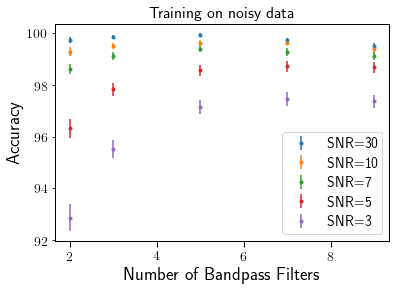

In [25]:
plt.figure(figsize=(6,4))
for ii in range(len(snr_levels)):
    plt.errorbar(Nchoose_array, best_accuracy_noise[ii, :, 0]*100, 
                 best_accuracy_noise[ii, :, 1]*100., fmt='.', 
                 color="C{}".format(ii),
                label="SNR={}".format(snr_levels[ii]))
plt.legend()
plt.xlabel('Number of Bandpass Filters')
plt.ylabel('Accuracy')
plt.title('Training on noisy data', fontsize=16)

### Next steps: 

 - Split into training, cross validation, and test sets, so that there's less cross-talking between training and test classification. Use the cross validation set to find the optimized filter combinations and apply to test set to quantify accuracy.
 - Investigate weird drop-off at high N end
 - Since exo-Earth candidates are the most important planet class to distinguish, look at accuracy of Modern/Prot/Archean Earth results only and see if accuracy is comparable to overall classification accuracy. The expectation is that they should be comparable, given the labels standardization and relatively equal distribution of labels between training & test sets. 